In [28]:
#!/usr/bin/env python3

# Script to load the CLIMATE DATA .Rdata files and grid them and convert them to netcdf files per variable
# uses the .RData files retrieved from the RMI Oracle databse through the climate_grid_daily.txt script from Bert Van Schaeybroeck

# I. Vanderkelen, June 2024

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import xarray as xr
import pandas as pd
from datetime import date
import numpy as np

# activate r to pandas convertor
pandas2ri.activate()


# user settings
variables = ["EVAPOTRANS_REF", "SUN_INT", "SUN_DURATION", "PRECIP_DURATION", "WIND_PEAK_SPEED",
	         "PRECIP_1H_MAX", "EVAPOTRANS_REF", "TEMP_MAX","HUMIDITY_RELATIVE","TEMP_MIN", "TEMP_AVG",
	         "WIND_SPEED", "PRESSURE", "SHORT_WAVE_FROM_SKY", "SUN_INT_HORIZ", "PRECIP_QUANTITY"]

# load climategrid meta data 
meta = pd.read_csv('CLIMATE_GRID_meta.csv', delimiter=";")

start_yr = 1950
end_yr = 2023
dates = pd.date_range(start=f'{start_yr}-01-01', end=f'{end_yr}-12-31', freq='D')

data_dir = '/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/CLIMATE_GRID/'


for variable in variables: 
	print('Converting '+ variable)

	filename = 'climate_atlas_'+str(variable)+'_CLIMATE_GRID_'+str(start_yr)+'_'+str(end_yr)+'.Rdata'

	# load the robject
	robjects.r['load'](data_dir+filename)

	# load the pixel lat and lon variable and use this to transpose to own defined grid
	df_coords =  pandas2ri.rpy2py(robjects.r['grid.pt.lst'])


	# define own grid  (in the original data, the delta's are not always the same, but the overall distance is similar)
	lons = df_coords['PIXEL_LON_CENTER']
	lon_min = lons.min()
	lon_max = lons.max()
	delta_lon = 0.0699 #°
	lon_grid = np.arange(lon_min,lon_max+delta_lon,delta_lon)

	lats = df_coords['PIXEL_LAT_CENTER']
	lat_min = lats.min()
	lat_max = lats.max()
	delta_lat = 0.045 #°
	lat_grid = np.arange(lat_min,lat_max+delta_lat,delta_lat)


	# Find the nearest index in the lons and lats grids and add this to coordinates dataframe
	def find_nearest(array, value):
		idx = (np.abs(array - value)).argmin()
		return idx

	df_coords['LON_INDEX'] = df_coords['PIXEL_LON_CENTER'].apply(lambda x: find_nearest(lon_grid, x))
	df_coords['LAT_INDEX'] = df_coords['PIXEL_LAT_CENTER'].apply(lambda x: find_nearest(lat_grid, x))


	# load the vector data
	data_raw = robjects.r['grid.arr']

	#reshape around time-axis
	ntime = data_raw.shape[1] * data_raw.shape[2] * data_raw.shape[3]
	data = data_raw.reshape(1360, ntime)

	# reshape around lat lon axis

	# create empty array to fill with gridded data
	grid_data = np.full(( ntime,  len(lat_grid),len(lon_grid)  ), np.nan)

	# Fill the grid data array
	for index, row in df_coords.iterrows():
		lat_idx = int(row['LAT_INDEX'])
		lon_idx = int(row['LON_INDEX'])
		pixel_id = int(row['PIXEL_ID'])
		
		grid_data[:, lat_idx, lon_idx ] = data[int(pixel_id) - 1, :]


	# time selection - the GRIDDATA is downloaded up to the last day 
	# only select full years here
	grid_data = grid_data[:len(dates),:,:]


	# get metadata from meta dataframe
	unit = meta.loc[meta['variable'] == variable, 'unit'].values[0] 
	long_name = meta.loc[meta['variable'] == variable, 'long_name'].values[0] 
	description = meta.loc[meta['variable'] == variable, 'description'].values[0] 

	# create data array
	da = xr.DataArray(
		data=grid_data,
		dims=["time",  "lat", "lon"],
		coords=dict(
			lon=lon_grid,
			lat=lat_grid,
			time=dates,
		),
		attrs=dict(
			long_name=long_name,
			description = description,
			units=unit,
		),
	)

	da['lat'].attrs = {'units':"degrees_north", 'long_name': "latitude"}
	da['lon'].attrs = {'units':"degrees_east", 'long_name': "longitude"}

	# convert to dataset and give dataset attributes
	ds = da.to_dataset(name=variable)
	d_attrs = {"creation_date": date.today().strftime("%d-%m-%Y"), "creators": "Ghilain N., Van Schaeybroeck B., Vanderkelen I.", 
	"contact": "inne.vanderkelen@meteo.be", "version": "1.1", "affiliation": "Royal Meteorological Institute of Belgium"}
	ds.attrs = d_attrs

	# export to netcdf
	filename_out = str(variable)+'_CLIMATE_GRID_'+str(start_yr)+'_'+str(end_yr)+'_daily.nc'
	ds.to_netcdf(data_dir + filename_out, encoding={'time':  {'dtype': 'int32'} })



Converting EVAPOTRANS_REF
Converting SUN_INT
Converting SUN_DURATION
Converting PRECIP_DURATION
Converting WIND_PEAK_SPEED
Converting PRECIP_1H_MAX
Converting EVAPOTRANS_REF
Converting TEMP_MAX
Converting HUMIDITY_RELATIVE
Converting TEMP_MIN
Converting TEMP_AVG
Converting WIND_SPEED
Converting PRESSURE
Converting SHORT_WAVE_FROM_SKY
Converting SUN_INT_HORIZ
Converting PRECIP_QUANTITY


In [30]:
robjects.r['load'](data_dir + filename)

# List all objects in the R environment
all_objects = robjects.r.ls()

# Print all objects
print("Objects in R environment after loading the file:")
for obj in all_objects:
    print(obj)

Objects in R environment after loading the file:
grid.arr
grid.pt.lst
grid.vec
munic.arr
munic.vec


In [34]:
df_coords =  robjects.r['grid.arr']
df_coords

array([[[[7.690e+00, 4.370e+00, 0.000e+00, ..., 3.300e-01, 3.000e-02,
          0.000e+00],
         [0.000e+00, 5.000e-02, 1.640e+00, ...,       nan,       nan,
                nan],
         [9.400e-01, 7.670e+00, 2.600e-01, ..., 1.880e+00, 1.930e+00,
          1.990e+00],
         ...,
         [0.000e+00, 0.000e+00, 0.000e+00, ..., 7.500e-01, 6.520e+00,
          1.138e+01],
         [1.310e+00, 3.840e+00, 5.320e+00, ..., 2.150e+00, 1.530e+00,
                nan],
         [5.500e-01, 9.200e-01, 9.700e-01, ..., 7.200e-01, 2.730e+00,
          2.455e+01]],

        [[9.610e+00, 1.056e+01, 1.610e+00, ..., 0.000e+00, 4.300e-01,
          2.254e+01],
         [9.450e+00, 4.400e-01, 2.020e+00, ..., 8.800e-01,       nan,
                nan],
         [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.305e+01, 0.000e+00,
          4.490e+00],
         ...,
         [2.170e+00, 6.830e+00, 6.390e+00, ..., 1.730e+00, 4.850e+00,
          8.900e-01],
         [1.141e+01, 1.287e+01, 1.910e+00, ..., 5.

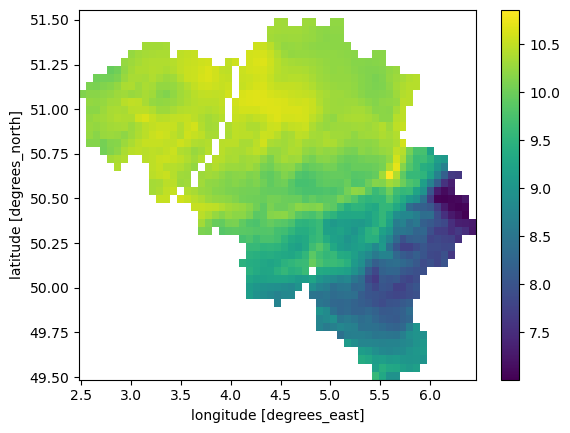

In [ ]:
da.mean(dim=('time')).plot()